# A Practical Introduction to Graph Neural Networks
> Message passing explained with examples

- toc: false 
- badges: true
- comments: true
- categories: [graph neural networks, GNN, message passing, tutorial]
- image: images/gnn/gnn_thumbnail.png
- permalink: /intrognn/

<center><div id="anim_container"><img alt="Illustration of GNN" src="https://mlabonne.github.io/blog/images/gnn/gnn.png" loading="lazy" id="anim_inner"></div></center>

Graph Neural Networks (GNNs) are one of the **most interesting architectures in deep learning**. In just a few years, they managed to apply neural networks to a **whole new set of problems**: drug discovery where **they found a new antibiotic** (Halicin), in Google Maps where they outperform any other method to **estimate the time of arrival**, and they now even **recommend every article, video, or connection** you see on all big social media. GNNs are a technology with **tremendous potential and countless applications** still untapped and yet to be discovered.

Despite these achievements, GNNs are **not as widely taught as other architectures** like Convolutional Neural Networks (CNNs). Because of their **young age**, educational resources are **scarcer and more research-oriented**, which can discourage many practitioners. In this article, we're going to do **node classification with graph data** using PyTorch Geometric (or PyG). Once we understand how to interact with this specific type of data, we will try to understand the core of GNNs: the **message passing layer**. Finally, we'll **implement a GNN** and **visualize how it learns and understands our graph data**.

The first step is to **install the libraries** we'll need throughout this article. We assume that [PyTorch](https://pytorch.org/) is already installed, which is the case on Google Colab. If you don't have PyTorch in your environment, **please follow the instructions** given in the [official documentation](https://pytorch.org/get-started/locally/). Moreover, some extensions of PyTorch can be quite difficult to install because it depends on your **version of PyTorch and CUDA**. If the installation does not work for you, please check [PyTorch Geometric's documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [1]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import networkx as nx

## 🌐 I. Graph data

<a href="https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)">Graphs</a> are a **type of data** you can find pretty much everywhere: social networks, computer networks, molecules, etc. Even **text and images** can be seen as graphs, as we're gonna see later. In this article, we're gonna study the **infamous and much-used** [Zachary's karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) dataset. It has somewhat of a **special aura** in the community, and no course about graphs would be complete without it.

<center><div id="anim_container"><img alt="Zachary's karate club" src="https://mlabonne.github.io/blog/images/gnn/zachary.png" loading="lazy" id="anim_inner" width="600"></div></center>

Zachary's karate club simply represents the **relationships within a karate club** studied by Wayne W. Zachary in the 1970s. It is a kind of **social network**, where every **node is a member**, and members who interacted outside the club are **connected together**. In this example, the club is **divided into 4 groups**: we would like to **assign the right group to every member** (node classification) just by looking at their **connections**. You can see it's quite similar to **friend suggestions** on social media, which is another task you can perform with GNNs: **link prediction**.

Let's import the dataset with PyG's built-in function and try to understand the `Datasets` object it uses.

In [2]:
from torch_geometric.datasets import KarateClub

# Import dataset from PyTorch Geometric
dataset = KarateClub()

# Print information
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

KarateClub()
------------
Number of graphs: 1
Number of features: 34
Number of classes: 4


This dataset **only has 1 graph**, where **each node** has a **feature vector of 34 dimensions** and is part of one out of **4 classes** (our 4 groups). Actually, the `Datasets` object can be seen as a **collection** of `Data` (graph) objects. We can further inspect our unique graph to know more about it.

In [3]:
# Print first element
print(f'Graph: {dataset[0]}')

Graph: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


The [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html) object is particularly interesting. Printing it offers a **good summary of the graph** we're studying:
* `x=[34, 34]` is the **node feature matrix** with shape (number of nodes, number of features). In our case, it means that we have 34 nodes (our 34 members), each node being associated to a 34-dim feature vector.
* `edge_index=[2, 156]` represents the **graph connectivity** (how the nodes are connected) with shape (2, number of directed edges).
* `y=[34]` is the **node ground-truth labels**. In this problem, every node is assigned to one class (group), so we have one value for each node.
* `train_mask=[34]` is an optional attribute that tells which **nodes should be used for training** with a list of `True` or `False` statements.

Let's print each of these parameters to understand what they store.

In [4]:
data = dataset[0]

# Print x
print(f'x = {data.x.shape}')
print(data.x)

x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


Here, the **node feature matrix** `x` is actually an **identity matrix**: it doesn't contain any **relevant information** about the nodes. It **could contain things** like age, skill level, etc. but this is not the case in this dataset. We'll have to classify our nodes **just by looking at their connections**.

In [5]:
# Print edge_index
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3, 

The `edge_index` has a quite **counter-intuitive way of storing the graph connectivity**. Here, we have 156 directed edges (78 bidirected edges) twice because the first 156-dim array contains the sources and the second one the destinations. It is called a **coordinate list (COO)** and is just [one way of efficiently storing a **sparse matrix**](https://en.wikipedia.org/wiki/Sparse_matrix#Storing_a_sparse_matrix). A more intuitive way to represent the graph connectivity would be a simple **adjacency matrix** $A$, where **nodes are rows and columns** and **1s indicate a connection** between two nodes.

<center><div id="anim_container"><img alt="Adjacency matrix" src="https://mlabonne.github.io/blog/images/gnn/adjacency.png" loading="lazy" id="anim_inner"></div></center>

The adjacency matrix **can actually be calculated** from the `edge_index` with a utility function.

In [6]:
from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

A = (34, 34)
[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


Unfortunately, it is **not an optimal way of storing this information**, since nodes are **not highly interconnected**. It means that our adjacency matrix is **filled with zeros** (sparse matrix) to indicate that there's **no connection between nodes**. Storing so many zeros is **not efficient at all**, which is why the COO format is adopted by PyG.

In [7]:
# Print y
print(f'y = {data.y.shape}')
print(data.y)

y = torch.Size([34])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


On the contrary, **node ground-truth labels** `y` are quite straightforward: they simply encode the **group number** (0, 1, 2, 3) for each node.

In [8]:
# Print train_mask
print(f'train_mask = {data.train_mask.shape}')
print(data.train_mask)

train_mask = torch.Size([34])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


Finally, the `train_mask` shows which nodes are **supposed to be used for training** with `True` statements. This is not super useful because **we don't have test data** anyway... 👀

But we're not done yet! The [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html) object has a lot more to offer: numerous **properties about graphs can be checked** using utility functions. For instance, `is_directed()` can tell you if the **graph is directed**, which means that **all the edges are unidirectional**. Another useful one is `isolated_nodes()` to check if some **nodes are not connected to the rest of the graph**. Finally, `has_self_loops()` can tell you if at least **one node is connected to itself**. This is **not the same as <a href="https://en.wikipedia.org/wiki/Loop_(graph_theory)#:~:text=In%20graph%20theory%2C%20a%20loop,connects%20a%20vertex%20to%20itself.&text=Where%20graphs%20are%20defined%20so,calling%20it%20a%20simple%20graph.">loops</a>**: loops mean that you can take a **path that starts and ends at the same node** (unlike a tree).

In [9]:
print(f'Flows are unidirectionnal: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.contains_isolated_nodes()}')
print(f'Graph has loops: {data.is_undirected()}')

Flows are unidirectionnal: False
Graph has isolated nodes: False
Graph has loops: True


D:\Programs\Anaconda\envs\blog\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)


One of the **coolest utility functions** available in PyG is [`to_networkx`](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html?highlight=to_networkx#torch_geometric.utils.to_networkx). It allows you to convert your `Data` instance into a `networkx.Graph` to **easily visualize it**. We can use `matplotlib` to plot the graph with **colors corresponding to the label of every node**.

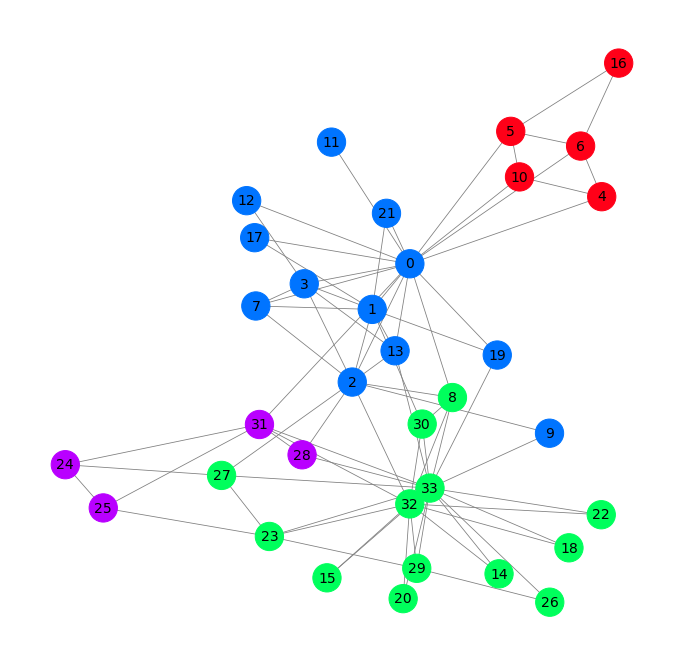

In [10]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

Okay, we plotted the Zachary's karate club dataset and can visualize our **34 nodes, 78 edges, and 4 labels with 4 different colours**. I think our understanding of the problem is now strong enough to **talk a bit more about GNNs** and their core component: **message passing**.

## ✉️ II. Message Passing

### 1. Redesigning message passing from convolution

<center><div id="anim_container"><img alt="Example of convolution" src="https://mlabonne.github.io/blog/images/gnn/convolutioncat.png" loading="lazy" id="anim_inner"></div></center>

In image processing, filters to blur, sharpen, or detect edges are all based on the same operation: a **convolution between a matrix and an image**. In the case of a $3 \times 3$ matrix, this operation looks at the **8 pixels around each pixel** and **apply weights to their values**. These values can be a **single number**, or a **vector containing multiple numbers**. In the previous figure, the same weight is applied to **every neighboring pixel**: each pixel becomes an **average of its neighbors**, which is why the result looks blurry. Different filters can be designed just by **changing the value of these weights**. Now, we could think of **each pixel as a node** and the **entire image as a graph**. The operation would be exactly the same.

<center><div id="anim_container"><img alt="Image as a graph" src="https://mlabonne.github.io/blog/images/gnn/convolutiongraph.png" loading="lazy" id="anim_inner"></div></center>

Why is that relevant? In graphs, **similar nodes are more likely to be connected to each other than dissimilar ones** (it's called [network homophily](https://en.wikipedia.org/wiki/Network_homophily)). Information about each node is stored in a feature vector, but we can get **even more information about a node just by aggregating its features with those of its neighbors**. This operation is called **convolution** for images, and **message passing** in GNNs. Message passing is a **confusing name**: the idea behind it is that nodes send "messages" (feature vectors) to each other, but it is actually **just a simple neighborhood aggregation**.

Let's take an example: we want to aggregate the feature vectors of the **pixel $5$ with those of its 8 neighbors**. Usually, pixels contain **3 values to encode the 3 primary colors** red, green, and blue, so each feature vector can be noted $\mathbf{x}_i = [r_i, g_i, b_i]$. As in a convolution operation, we **multiply $\mathbf{x}_5$ and the neighboring nodes' feature vectors by a matrix** $W$. Note that in this case, $\mathbf{W}_i$ are **not single values**, but vectors because they have to take into account three values for each $\mathbf{x_i}$ ($r_i$, $g_i$, $b_i$). In other words, we have a **weight matrix $W$ containing 9 weight vectors $\mathbf{W_i}$**. We call the list of pixel $5$ and its neighbors $\tilde{N}(5) = \{1, 2, 3, 4, 5, 6, 7, 8, 9\}$. The result $\mathbf{h}_5$ of this aggregation can be calculated as follows:

$$\mathbf{h}_5 = \mathbf{W}_1\mathbf{x}_1 + \dots + \mathbf{W}_9\mathbf{x}_9 = \sum_{i \in \tilde{N}(5)} \mathbf{\mathbf{W}_{i}\mathbf{x}_i}$$

We could apply the same idea to graphs in general, but there's a problem: **nodes do not have a consistent order like pixels do**. If we change the order from $\{1, 2, 3, 4, 5, 6, 7, 8, 9\}$ to $\{9, 3, 1, 4, 7, 6, 2, 5, 8\}$, we would **obtain a different result**. It makes sense with images, but nodes can't be to the left or to the right of other nodes, they **don't have positions**! It means that we never know if the nodes are going to be **in the correct order**, so we can't assign $\mathbf{W}_i$ to $\mathbf{x}_i$. Okay then, a simple solution is **to reuse the same weight vector $\mathbf{W}$ for every $\mathbf{x}_i$**, instead of having a unique weight vector $\mathbf{W}_i$ for each node. That way, the **same operation is performed** whatever the node is. The formula now becomes:

$$\mathbf{h}_5 = \sum_{i \in \tilde{N}(5)} \mathbf{Wx}_i$$

But unlike pixels, nodes do not have a fixed number of neighbors. What if one node only has **1 neighbor**, and another one has **500 of them**? We would add **500 values instead of just one**, which means that the result $\mathbf{h}$ would be **much larger for the node with 500 neighbors**. But it doesn't make sense: nodes should always be **comparable so they need to have a similar range of values**. To address this issue, we can **normalize the result based on the number of neighbors**. In graph theory, this number is called a **degree**. Let's **divide the result** of the previous formula by the number of neighbors of node $5$ (noted $deg(5)$):

$$\mathbf{h}_5 = \dfrac{1}{deg(5)} \sum_{i \in \tilde{N}(5)} \mathbf{W} \mathbf{x}_i$$

Excellent! We now have a **message passing layer**. There are **other types** of message passing, but this one is **simple and works fairly well**. We had to overcome two issues compared to a convolution operation:

1. **Nodes don't have any idea of order**, which forced us to use a common weight $\mathbf{W}$;
2. **Nodes have a variable number of neighbors**, which pushed us to normalize our result by dividing it by the number of neighbors $deg(5)$.

### 2. (Optional) Message passing with matrices

Naturally, this way of **computing message passing node by node** is **not very efficient**. Since we're talking about neural networks, it means that calculations are performed through **matrix multiplication**. Let's **go back to our dataset** and **translate the previous operations into matrices**. First, we have `data.x`, which is the feature node matrix $X$. In this particular dataset, $X$ is the identity matrix $I$ but, in general, **it could store any information** about the nodes.

In [11]:
# We convert data.x from a torch.tensor object to
# a numpy array with integers instead of floats
X = data.x.numpy().astype(int)

print(f'X = {X.shape}')
print(X)

X = (34, 34)
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


Now we need $W$, the **learnable weight matrix** (like a filter) of our message passing layer. Our layer is not trained yet, so we can initialize $W$ with **arbitrary values**. To keep things simple, let's take the **identity matrix** again, so $W X = I \times I = I$.

In [12]:
W = np.identity(X.shape[0], dtype=int)

print(f'W = {W.shape}')
print(W)

W = (34, 34)
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


We can apply the weights in $W$ to every feature vector by calculating $WX$, but this is **not what we want to do**! Indeed, we only need to **include the neighboring nodes** and **not every node in the graph**. A nice way to find these neighbors is to look at the **adjacency matrix** $A$ we saw earlier.

In [13]:
print(f'A = {A.shape}')
print(A)

A = (34, 34)
[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


In our case, $A$ is **symmetrical** because **edges in this graph are bidirectional**. This wouldn't be the case if connections were **unidirectional**. This is why we use $A^T X$ and not $AX$ in general in order to obtain the **feature vectors of the neighboring nodes**. This operation does not only select the **relevant vectors**, it also **sums them** in the process.

<center class="dark-bg">
    <video autoplay loop muted width="800" class="no-margin">
        <source src="https://mlabonne.github.io/blog/images/gnn/matrixmul_compressed.mp4" type="video/mp4"></source>
    </video>
</center>

We just miss the "central" node itself, which can be fixed by **adding a connection to itself** (self-loops) in the adjacency matrix: $\tilde{A} = A + I$.

In [14]:
A_tilde = A + np.identity(A.shape[0], dtype=int)

print(f'\nA_tilde = {A_tilde.shape}')
print(A_tilde)


A_tilde = (34, 34)
[[1 1 1 ... 1 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 1 0]
 ...
 [1 0 0 ... 1 1 1]
 [0 0 1 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


$\tilde{A}^TX$ **selects the feature vectors** of the neighboring nodes (and the node itself) and $WX$ **applies the weights** in $W$ to every feature vector in the graph. We can combine both expressions to **apply these weights to the feature vectors of the neighboring nodes** (and the node itself) with $\tilde{A}^T \ X \ W^T$. We can rewrite the previous operation as follows:

$$h_v = \sum_{i \in \tilde{N}(v)} W x_i$$

<center>becomes</center>

$$H = \tilde{A}^T \ X \ W^T$$

In [15]:
# @ is numpy operator for matrix multiplication
H = A_tilde.T @ X @ W.T

print(f'H = A_tilde.T @ X @ W.T {H.shape}')
print(H)

H = A_tilde.T @ X @ W.T (34, 34)
[[1 1 1 ... 1 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 1 0]
 ...
 [1 0 0 ... 1 1 1]
 [0 0 1 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


Now we would like to **normalize** $H$ by the number of neighbors as seen previously. We can use the **degree matrix** $D$ that **counts the number of neighbors for each node**. In our case, we want the matrix $\tilde{D}$, based on $\tilde{A}$ instead of $A$.

In [16]:
D = np.zeros(A.shape, dtype=int)
np.fill_diagonal(D, A.sum(axis=0))

print(f'D = {D.shape}')
print(D)

D_tilde = np.zeros(D.shape, dtype=int)
np.fill_diagonal(D_tilde, A_tilde.sum(axis=0))

print(f'\nD_tilde = {D_tilde.shape}')
print(D_tilde)

D = (34, 34)
[[16  0  0 ...  0  0  0]
 [ 0  9  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0 17]]

D_tilde = (34, 34)
[[17  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0 11 ...  0  0  0]
 ...
 [ 0  0  0 ...  7  0  0]
 [ 0  0  0 ...  0 13  0]
 [ 0  0  0 ...  0  0 18]]


We could use D to calculate either:
* $\tilde{D}^{-1} \tilde{A}$ to **normalize every row** in $\tilde{A}$;
* $\tilde{A} \tilde{D}^{-1}$ to **normalize every column** in $\tilde{A}$. 

In our case, $\tilde{A}$ is **symmetrical** so the results would be the **equivalent**. We can thus translate the normalized operation as follows:

$$h_v = \dfrac{1}{|\tilde{N}(v)|} \sum_{i \in \tilde{N}(v)} W x_i$$

<center>becomes</center>

$$H = \tilde{D}^{-1} \ \tilde{A}^T \ X \ W^T$$

In [17]:
D_inv = np.linalg.inv(D_tilde)
print(f'D_inv = {D_inv.shape}')
print(D_inv)

H = D_inv @ A_tilde.T @ X @ W.T
print(f'\nH = D_inv @ A.T @ X @ W.T {H.shape}')
print(H)

D_inv = (34, 34)
[[0.05882353 0.         0.         ... 0.         0.         0.        ]
 [0.         0.1        0.         ... 0.         0.         0.        ]
 [0.         0.         0.09090909 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.14285714 0.         0.        ]
 [0.         0.         0.         ... 0.         0.07692308 0.        ]
 [0.         0.         0.         ... 0.         0.         0.05555556]]

H = D_inv @ A.T @ X @ W.T (34, 34)
[[0.05882353 0.05882353 0.05882353 ... 0.05882353 0.         0.        ]
 [0.1        0.1        0.1        ... 0.         0.         0.        ]
 [0.09090909 0.09090909 0.09090909 ... 0.         0.09090909 0.        ]
 ...
 [0.14285714 0.         0.         ... 0.14285714 0.14285714 0.14285714]
 [0.         0.         0.07692308 ... 0.07692308 0.07692308 0.07692308]
 [0.         0.         0.         ... 0.05555556 0.05555556 0.05555556]]


And we're done! The previous operation is **exactly what a Graph Neural Network could do**. In reality, there are **many ways to define a message passing layer**. The good news is that it's handled by PyTorch Geometric, so we don't need to **reimplement GNN layers with matrix multiplication from scratch**. Now, let's see how it's done.

## 🧠 III. Graph Neural Network

One of the simplest GNN layer is called `GCNConv` in PyG for **Graph Convolutional Network**, and was introduced in [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907). The main idea is that feature vectors from nodes with a lot of neighbors will **spread very easily, unlike ones from more isolated nodes**. The authors proposed to use a **weighted average operation to counterbalance this effect**, by giving bigger weights to feature vectors from nodes with few neighbors. This operation can be written as follows:

$$h_v = \sum_{i \in \tilde{N}(v)} \dfrac{1}{\sqrt{deg(v)}\sqrt{deg(i)}} W x_i$$

Or with matrices:

$$H = \tilde{D}^{-1/2} \tilde{A}^T \tilde{D}^{-1/2} X W^T$$

Notice that is $v$ and $i$ have the **same number of neighbors**, it is **equivalent to our own message passing layer**.

In [18]:
# We calculate D^(-1/2) based on the fact it's a diagonal matrix
D_inv12 = np.linalg.inv(D_tilde)
np.fill_diagonal(D_inv12, 1/ (D_tilde.diagonal()**0.5))

# New H
H = D_inv12 @ A_tilde.T @ D_inv12 @ X @ W.T
print(f'\nH = D_inv12 @ A.T @ D_inv12 @ X @ W.T {H.shape}')
print(H)


H = D_inv12 @ A.T @ D_inv12 @ X @ W.T (34, 34)
[[0.05882353 0.0766965  0.07312724 ... 0.09166985 0.         0.        ]
 [0.0766965  0.1        0.09534626 ... 0.         0.         0.        ]
 [0.07312724 0.09534626 0.09090909 ... 0.         0.0836242  0.        ]
 ...
 [0.09166985 0.         0.         ... 0.14285714 0.10482848 0.08908708]
 [0.         0.         0.0836242  ... 0.10482848 0.07692308 0.06537205]
 [0.         0.         0.         ... 0.08908708 0.06537205 0.05555556]]


However, edges are not always bidirectional so nodes can have **different numbers of neighbors**. This is why the **result of this operation is different** from the one we designed. It is a clever trick to **take into account another difference** between graphs and images.

Actually, this layer is the **only difference between GNNs and regular neural networks**. Indeed, the result of the `GCNConv` layer is fed to a classic **non-linear activation function**, such as $tanh$ or $ReLU$ (otherwise it's just a fancy linear regression). Finally, since it's a classification task, we add a **linear layer $Z$ with 4 neurons** (our 4 groups) that outputs logits. In these logits, the maximum value of each row **determines the class** of a node.

$$X \to H(X) \to ReLU(H(X)) \to Z(ReLU(H(X)))$$

The definition of a GNN looks like a **regular PyTorch code**, with the addition of the `GCNConv` layer (courtesy of PyG). Here is a simple example with only one layer:

In [19]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.gcn = GCNConv(dataset.num_features, 3)
    self.out = Linear(3, dataset.num_classes)

  def forward(self, x, edge_index):
    h = self.gcn(x, edge_index)
    embedding = torch.relu(h)
    z = self.out(embedding)

    return h, embedding, z

model = GNN()
print(model)

GNN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


As you can imagine, adding a second GCN layer would allow the network to **not only aggregate feature vectors from the neighbors of each node**, but also **from the neighbors of these neighbors**. We can **stack several message passing layers** to aggregate more and more distant values, but there's a catch: if we add too many layers, **the aggregation becomes so intense** that all the nodes end up **looking the same** despite being vastly different. This phenomenon is called **over-smoothing** and can be a real problem. Fortunately, we don't have to worry about it in this example because **we only have one layer**.

Now that we've defined our GNN, let's write a **simple training loop** with PyTorch. I chose a regular **cross-entropy loss** since it's a multi-class classification task, with **Adam as optimizer**. We could use the `data.train_mask`, but since there is no test data, we can **solemnly ignore it** for the purpose of this exploratory exercise. The training loop is very standard: we **try to predict the correct labels**, and we **compare the results** given by $Z(ReLU(H))$ to the labels `data.y` from the dataset. The error **calculated by the cross-entropy loss** is **backpropagated with Adam** to fine-tune our GNN's weights and biases. Finally, we print metrics to see the progression every 10 epochs.

In [20]:
# Initialize GNN model
model = GNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    h, embedding, z = model(data.x, data.edge_index)

    # Calculate loss function
    loss = criterion(z, data.y)

    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    # Store data for animations
    embeddings.append(embedding)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 1.44 | Acc: 11.76%
Epoch  10 | Loss: 1.28 | Acc: 47.06%
Epoch  20 | Loss: 1.07 | Acc: 38.24%
Epoch  30 | Loss: 0.87 | Acc: 70.59%
Epoch  40 | Loss: 0.70 | Acc: 82.35%
Epoch  50 | Loss: 0.58 | Acc: 85.29%
Epoch  60 | Loss: 0.49 | Acc: 85.29%
Epoch  70 | Loss: 0.44 | Acc: 85.29%
Epoch  80 | Loss: 0.41 | Acc: 85.29%
Epoch  90 | Loss: 0.38 | Acc: 85.29%
Epoch 100 | Loss: 0.37 | Acc: 85.29%
Epoch 110 | Loss: 0.34 | Acc: 85.29%
Epoch 120 | Loss: 0.29 | Acc: 97.06%
Epoch 130 | Loss: 0.24 | Acc: 100.00%
Epoch 140 | Loss: 0.19 | Acc: 100.00%
Epoch 150 | Loss: 0.14 | Acc: 100.00%
Epoch 160 | Loss: 0.11 | Acc: 100.00%
Epoch 170 | Loss: 0.08 | Acc: 100.00%
Epoch 180 | Loss: 0.06 | Acc: 100.00%
Epoch 190 | Loss: 0.05 | Acc: 100.00%
Epoch 200 | Loss: 0.04 | Acc: 100.00%


Great! Without much surprise, we **reach 100% accuracy** on the training set. It means that our model learned to **correctly assign every member of the karate club to its correct group**. We can do something quite cool by **animating the graph to see the evolution of the GNN's predictions** during the training process.

In [21]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())

In [22]:
display(html)

The GNN **struggles a bit at the beginning**, but it **perfectly labels** every node after a while. Indeed, the final graph is **the same than the one we plotted** at the end of the first part of this article. Okay this is nice, but **what does the GNN really learn**?

We talked about **message passing as a generalized convolution operation**, where feature vectors from each neighboring node contribute to a **better understanding of the "central" node**. This is exactly what GNNs learn: a **representation of the information of every node**, also called an **embedding**. In our model, the linear classifier $Z$ on top of it **just learns how to use these embeddings** to produce the best classifications, but the embeddings are the **real product of GNNs**.

Let's **print the 3D embeddings for each of the 34 nodes** with the result of the ReLU layer $ReLU(H(x))$, aptly named `embedding`.

In [23]:
# Print embeddings
print(f'Final embeddings = {embedding.shape}')
print(embedding)

Final embeddings = torch.Size([34, 3])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.7755e-02, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.5279e+00, 3.4284e-01],
        [0.0000e+00, 1.5948e+00, 1.5541e-01],
        [0.0000e+00, 1.5861e+00, 2.2189e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.2247e+00, 1.1025e-01, 1.5806e+00],
        [5.7357e-02, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.5257e+00, 3.4660e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.6114e+00, 1.3823e-01, 1.6890e+00],
        [1.6025e+00, 1.7610e-01, 1.8602e+00],
        [0.0000e+00, 1.6044e+00, 3.0357e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.4584e+00, 1.5426e-01, 1.6852e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.4738e+00, 1.7071e-01, 1.7045e+

As you can see, embeddings **do not need to have the same dimensions** as feature vectors. Here, I chose to **reduce the number of dimensions** from 34 (`dataset.num_features`) to 3 to get a nice visualization in 3D. Let's plot these embeddings **before any training happens**, at epoch 0.

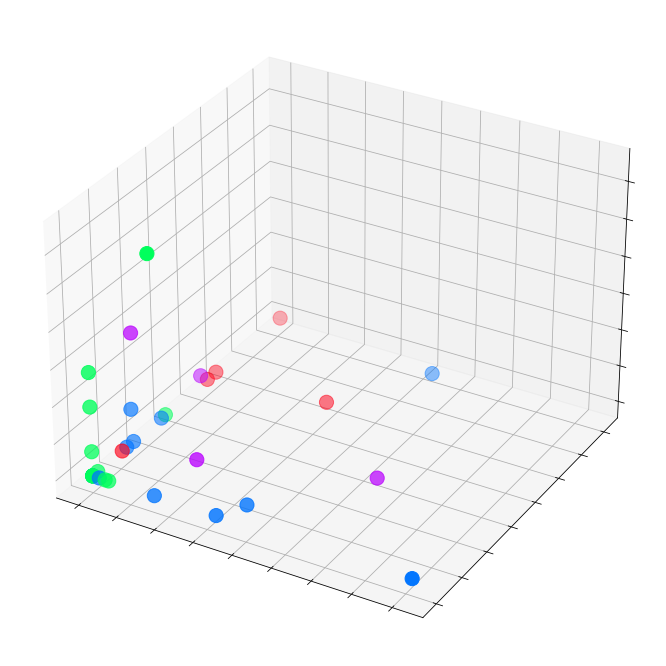

In [24]:
# Get first embedding at epoch = 0
embed = embeddings[0].detach().cpu().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)

plt.show()

Okay, we see **every node** from our graph, with the color corresponding to its **real group** (and not the model's prediction). For now, they're **all over the place** since the GNN is not trained yet. But if we plot **these embeddings at each step of the training loop**, we'd be able to **visualize what the GNN truly learns**. We would see how the embeddings **change over time**, as the GNN gets **better and better at classifying** nodes.

This is exactly what the following animation does.

In [25]:
%%capture

def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=40)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

anim = animation.FuncAnimation(fig, animate, \
              np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())

In [26]:
display(html)

Let's unpack it. During training, we know that **GNNs learn to produce the best embeddings** possible for a specific task. In practice, we see that it means **nodes from the same class are grouped into nice clusters**. It makes the job of the linear classification layer quite simple because **you can easily draw planes to separate each cluster**.

Embeddings are not unique to GNNs: they can be **found everywhere in deep learning**. They **don't have to be 3D** either: actually, they rarely are. For instance, language models like [BERT](https://arxiv.org/abs/1810.04805) produce embeddings with **768 or even 1024 dimensions** (and other models go much higher!). Additional dimensions allow to **store more information** about nodes, text, images, etc. but they also create bigger models that are **more difficult and take longer to train**. This is why it's **better to keep low-dimensional embeddings** as long as it's possible.

## 🔚 IV. Conclusion

Graph Neural Networks are a **powerful architecture** that is less difficult to understand than at first glance. In this article,

* We learned to use the **PyTorch Geometric library to explore graph data** with the `Datasets` and `Data` objects;
* We **redesigned a message passing layer from scratch**, based on a tweaked convolutional layer to work with graphs and not just images;
* We **implemented a real GNN with a GCN layer** that is very close to our own design;
* We **visualized what and how our GNN learns** with the clustering of the node embeddings.

Zachary's karate club is **not the best graph dataset** (feature vectors are useless), but it is good enough to **understand the most important concepts** in graph data and GNNs. We only talked about **node classification** in this work, but there are other tasks GNNs can accomplish: **link prediction** (e.g., to recommend a friend), **graph classification** (e.g., to label molecules), etc. Beyond GCN, **other GNN layers and architectures were proposed** by researchers. For instance, [Graph Attention Networks](https://arxiv.org/abs/1710.10903) (GATs) **implicitly compute GCN's normalization factor** with an attention mechanism, and [GraphSAGE](https://arxiv.org/abs/1706.02216) **randomly samples sets of nodes** to improve scalability.

If you enjoyed this article, **please share this article** and **[follow me on Twitter](https://twitter.com/maximelabonne)** for more cool visualizations. Thank you and have a great day! 📣